In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

First, we read the data and divide them into training and testing sets.

In [2]:
# Load datasets
X_all = pd.read_csv('train_X.csv')
y_all = pd.read_csv('train_y.csv')

X_all = X_all.set_index('Unnamed: 0')
y_all = y_all.set_index('Unnamed: 0')

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
y_train, y_test, y_all = y_train.values.ravel(), y_test.values.ravel(), y_all.values.ravel()

In [3]:
# Simple Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_score = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {lr_score:.4f}')

Logistic Regression Accuracy: 0.8427


Then we perform a binary classification using linear models, and measure the classification performance using accuracy and F1-score on the test set. A pipeline is used to try different models including Logistic Regression, Ridge Regression, LASSO Regression, and Linear Regression (in which we use the mean as the boundary between two classes).

In [4]:
scaler = StandardScaler()
models = {
    'LogisticRegression, none': LogisticRegression(max_iter=1000, penalty=None),
    'LogisticRegression, l1': LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear'),
    'LogisticRegression, l2': LogisticRegression(max_iter=1000),
    'RidgeRegression': Ridge(),
    'LassoRegression': Lasso(),
    'LinearRegression': LinearRegression()
}

# Train and evaluate models
for name, model in models.items():
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    if name == 'LinearRegression':
        y_pred_binary = y_pred > y_pred.mean()
    else:
        y_pred_binary = y_pred > 0.5
    
    print(f'{name} Accuracy: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'{name} F1-score: {f1_score(y_test, y_pred_binary):.4f}\n')

LogisticRegression, none Accuracy: 0.8090
LogisticRegression, none F1-score: 0.8283

LogisticRegression, l1 Accuracy: 0.7865
LogisticRegression, l1 F1-score: 0.8190

LogisticRegression, l2 Accuracy: 0.8652
LogisticRegression, l2 F1-score: 0.8846

RidgeRegression Accuracy: 0.8427
RidgeRegression F1-score: 0.8600

LassoRegression Accuracy: 0.5955
LassoRegression F1-score: 0.7465

LinearRegression Accuracy: 0.8090
LinearRegression F1-score: 0.8211



As shown above, logistic regression with L2 regularization is the best model, which gives us 0.8652 accuracy and 0.8846 F1-score. Then, we will change different C, the inverse of regularization strength, and find the best parameter.

In [5]:
def run_pipeline(models, parameters):
    for model in models:
        for parameter in parameters[model][1]:
            pipe = Pipeline([('scaler', StandardScaler()), (model, models[model])])
            score = eval(
                f'pipe.set_params({parameters[model][0]}=parameter).fit(X_train, y_train).score(X_test, y_test)'
            )
            print(f'{model}, C = {parameter} Accuracy: {score:.4f}')

In [6]:
models = {
    'LogisticRegression_l1': LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear'),
    'LogisticRegression_l2': LogisticRegression(max_iter=1000),
    'RidgeRegression': Ridge(),
    'LassoRegression': Lasso(),
}
parameters = {
    'LogisticRegression_l1': ['LogisticRegression_l1__C', [0.01, 0.1, 1, 10, 100]],
    'LogisticRegression_l2': ['LogisticRegression_l2__C', [0.01, 0.1, 1, 10, 100]],
    'RidgeRegression': ['RidgeRegression__alpha', [0.01, 0.1, 1, 10, 100]],
    'LassoRegression': ['LassoRegression__alpha', [0.01, 0.1, 1, 10, 100]]
}

run_pipeline(models, parameters)

LogisticRegression_l1, C = 0.01 Accuracy: 0.4045
LogisticRegression_l1, C = 0.1 Accuracy: 0.8090
LogisticRegression_l1, C = 1 Accuracy: 0.7978
LogisticRegression_l1, C = 10 Accuracy: 0.8427
LogisticRegression_l1, C = 100 Accuracy: 0.8202
LogisticRegression_l2, C = 0.01 Accuracy: 0.8764
LogisticRegression_l2, C = 0.1 Accuracy: 0.8652
LogisticRegression_l2, C = 1 Accuracy: 0.8652
LogisticRegression_l2, C = 10 Accuracy: 0.8539
LogisticRegression_l2, C = 100 Accuracy: 0.8427
RidgeRegression, C = 0.01 Accuracy: 0.4358
RidgeRegression, C = 0.1 Accuracy: 0.4358
RidgeRegression, C = 1 Accuracy: 0.4358
RidgeRegression, C = 10 Accuracy: 0.4360
RidgeRegression, C = 100 Accuracy: 0.4378
LassoRegression, C = 0.01 Accuracy: 0.4258
LassoRegression, C = 0.1 Accuracy: 0.2913
LassoRegression, C = 1 Accuracy: -0.0036
LassoRegression, C = 10 Accuracy: -0.0036
LassoRegression, C = 100 Accuracy: -0.0036


In [7]:
models = {'LogisticRegression_l2': LogisticRegression(max_iter=1000),}
parameters = {'LogisticRegression_l2': ['LogisticRegression_l2__C', list(np.arange(0.001, 0.01, 0.002))+list(np.arange(0.01, 0.1, 0.02))]}
run_pipeline(models, parameters)

LogisticRegression_l2, C = 0.001 Accuracy: 0.8652
LogisticRegression_l2, C = 0.003 Accuracy: 0.8764
LogisticRegression_l2, C = 0.005 Accuracy: 0.8764
LogisticRegression_l2, C = 0.007 Accuracy: 0.8764
LogisticRegression_l2, C = 0.009000000000000001 Accuracy: 0.8764
LogisticRegression_l2, C = 0.01 Accuracy: 0.8764
LogisticRegression_l2, C = 0.03 Accuracy: 0.8652
LogisticRegression_l2, C = 0.049999999999999996 Accuracy: 0.8652
LogisticRegression_l2, C = 0.06999999999999999 Accuracy: 0.8652
LogisticRegression_l2, C = 0.08999999999999998 Accuracy: 0.8652


Therefore, logistic regression with C=0.01 and L2 regularization is the best model.

In [8]:
# Random Guessing
y_pred_random = np.random.choice(y_train, len(X_test))

print(f'Randomized Labels Accuracy: {accuracy_score(y_test, y_pred_random):.4f}')
print(f'Randomized Labels F1-score: {f1_score(y_test, y_pred_random):.4f}')

Randomized Labels Accuracy: 0.4270
Randomized Labels F1-score: 0.5143


In [9]:
(0.8764 - 0.5618) / 0.8764

0.35896850753080783

The best model accuracy is 35.9% higher than the random guessing accuracy. Now we can discover the most affective genes in our best model.

In [10]:
best_model = Pipeline([('scaler', StandardScaler()), ('LogisticRegression_l2', LogisticRegression(max_iter=1000, C=0.01))])
best_model.fit(X_train, y_train)
coefficients = best_model.named_steps['LogisticRegression_l2'].coef_[0]

Here is the top ten genes that positively correlated to the existance of III+ tumor.

In [11]:
genes_with_coef = sorted(list(zip(coefficients, X_test.columns)))
genes_with_coef[:-11:-1]

[(0.024647265614741384, 'ENSG00000180316'),
 (0.020715829395190233, 'ENSG00000177947'),
 (0.019678486466877282, 'ENSG00000144290'),
 (0.017874001913765387, 'ENSG00000004848'),
 (0.017635169646164676, 'ENSG00000135116'),
 (0.017508176283146864, 'ENSG00000011201'),
 (0.017358809801370046, 'ENSG00000121351'),
 (0.017285261487871108, 'ENSG00000241598'),
 (0.017278837659291738, 'ENSG00000130595'),
 (0.016631639709927874, 'ENSG00000115507')]

Also, we have the top ten genes that negatively correlated to the existance of III+ tumor.

In [12]:
genes_with_coef[:10]

[(-0.023806659599672306, 'ENSG00000198812'),
 (-0.02232821204054895, 'ENSG00000204928'),
 (-0.019693255688116012, 'ENSG00000272804'),
 (-0.019349786939642163, 'ENSG00000212657'),
 (-0.01886339617463663, 'ENSG00000221813'),
 (-0.018452432760242596, 'ENSG00000183269'),
 (-0.018338500447524303, 'ENSG00000134443'),
 (-0.01820159842379354, 'ENSG00000244588'),
 (-0.018034199430935795, 'ENSG00000189280'),
 (-0.018014501784434967, 'ENSG00000176904')]

In the following plot, we visualize the coefficients of each gene in our best model, where a negative value indicate negative correlation, and the absolute value indicates the importance.

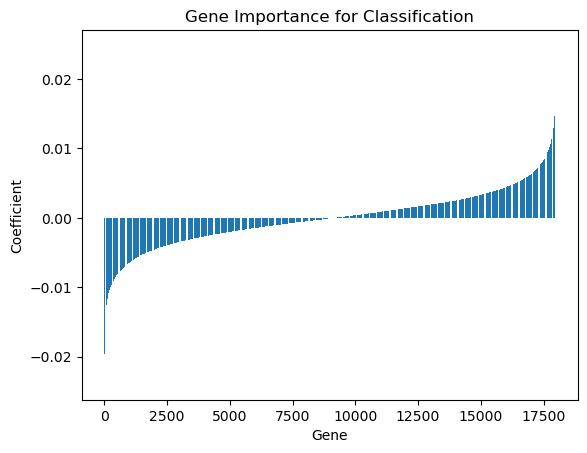

In [13]:
plt.bar(range(len(coefficients)), sorted(coefficients))
plt.xlabel('Gene')
plt.ylabel('Coefficient')
plt.title('Gene Importance for Classification')
plt.show()

Using PCA, we can reduce the dimensionality to two, and visualize the patients in two colors. First, let's check the distribution of all data.

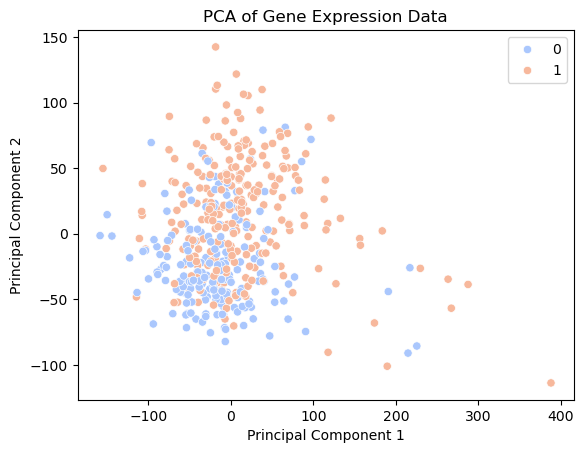

In [14]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Visualize the 2D projection
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_all, palette='coolwarm')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Gene Expression Data')
plt.show()

Then, we plot two graphs to compare the actual labels and our predictions. The result shows that most of our predictions are correct.

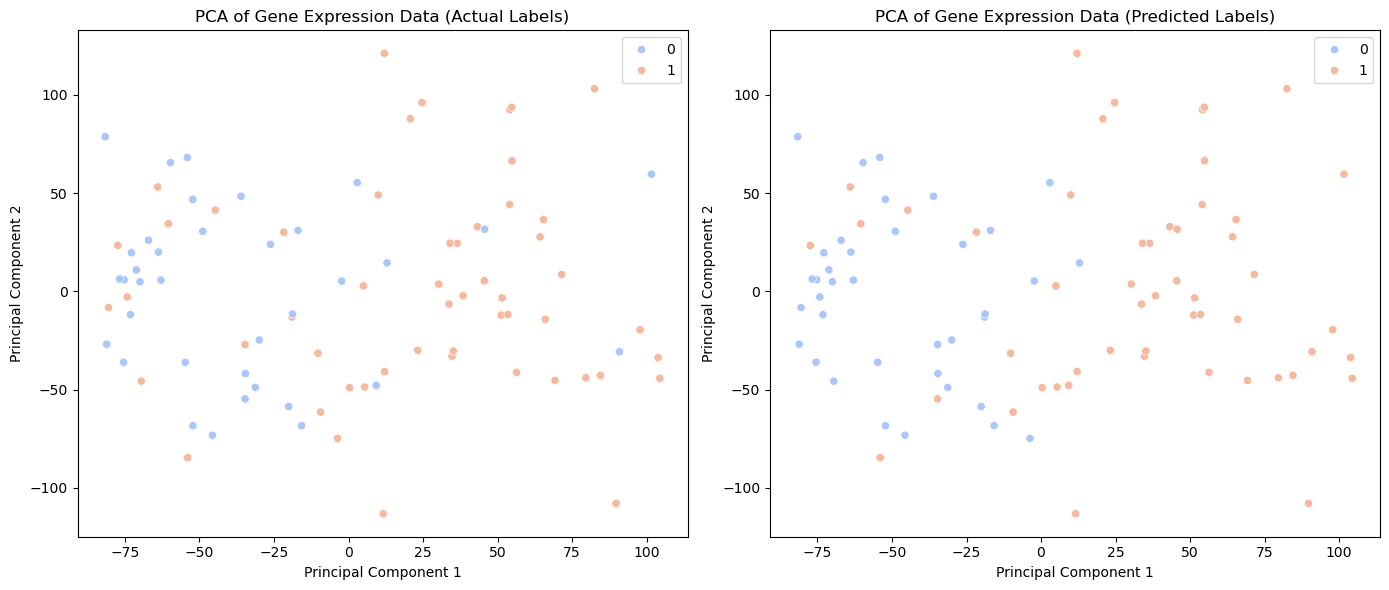

In [15]:
# Perform PCA on the test data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the actual labels
sns.scatterplot(ax=axes[0], x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='coolwarm')
axes[0].set_title('PCA of Gene Expression Data (Actual Labels)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot the predicted labels
y_pred = best_model.predict(X_test)
sns.scatterplot(ax=axes[1], x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette='coolwarm')
axes[1].set_title('PCA of Gene Expression Data (Predicted Labels)')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [25]:
# train the model with all data
final_model = Pipeline([('scaler', StandardScaler()), ('LogisticRegression_l2', LogisticRegression(max_iter=1000, C=0.01))])
final_model.fit(X_all, y_all)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LogisticRegression_l2',
                 LogisticRegression(C=0.01, max_iter=1000))])

In [26]:
# make predictions
test_data = pd.read_csv('test_X.csv').set_index('Unnamed: 0')
predictions = final_model.predict(test_data)
output = pd.DataFrame({
    'ID': test_data.index,
    'xml_neoplasm_histologic_grade': predictions
})
output.to_csv('predictions.csv', index=False, header=True)